# SESSION_4

Prerequisites: In a terminal, You need to create, install biopython and activate the `Conda` env as follow before to start jupyter

**We will create a new env called curso_4**

!conda create -y --name curso_4

!conda install -y -n curso_4 -c bioconda -c conda-forge mummer gepard racon nanopolish minimap2 jupyter

Problem with Nanopolish

**for MacOs users: you may have problem with mummer v.3 installed using conda**.  If you have troubles, you should install mummer4 using a regulation installation, see here :  (https://mummer4.github.io/install/install.html)

!conda activate curso_4

!jupyter notebook &

# Polishing Assemblies

What is “genome polishing”?

“Genome polishing,” sometimes referred to as “genome finishing,” is a workflow in which assembly software searches for local misassemblies and other inconsistencies in a draft genome assembly and then corrects them. Genome polishing can be used to create hybrid assemblies with Illumina data and long read sequencing data and is especially valuable for enhancing assembly results where there are concerns about single molecule or nanopore sequencing accuracy. (https://www.dnastar.com/blog/dnastar-news/genome-polishing-benchmarks/)

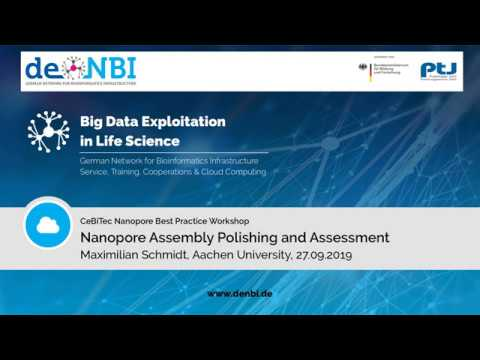

In [2]:
from IPython.display import YouTubeVideo

YouTubeVideo('jCVkHq9dlGs', 560, 315)

# CALCULATING DIFFERENCES BETWEEN ASSEMBLIES

In the previous session we assembled the b. subtilis genome without  error correction of reads. The accuracy of such assemblies equals to the base accuracy of sequenced reads and is unusable for many downstream analyses. 
Let us check the actual error with `dnadiff`.

We can now run `dnadiff` from the `mummer` package, which is a tool for calculating differences between two genome and providing a detailed summary. Try with the different assembly done at session_3.  
(see http://mummer.sourceforge.net)

In [1]:
!dnadiff -h

/bin/bash: /opt/anaconda3/envs/curso_4/bin/dnadiff: /usr/local/bin/perl: bad interpreter: No such file or directory


In [ ]:
!dnadiff -p bs_assembly_miniasm data/bacillus_subtilis/bs_ref.fasta data/bacillus_subtilis/bs_assembly_miniasm.fasta

In [4]:
!cat bs_assembly_miniasm.report

/Users/guyot/Piracicaba_ESALQ_2023/Session_4/data/bacillus_subtilis/bs_ref.fasta /Users/guyot/Piracicaba_ESALQ_2023/Session_4/bs_assembly_miniasm.fasta
NUCMER

                               [REF]                [QRY]
[Sequences]
TotalSeqs                          1                    1
AlignedSeqs              1(100.0000%)          1(100.0000%)
UnalignedSeqs             0(0.0000%)           0(0.0000%)

[Bases]
TotalBases                   4045677              3931083
AlignedBases       3845046(95.0409%)    3733242(94.9673%)
UnalignedBases       200631(4.9591%)      197841(5.0327%)

[Alignments]
1-to-1                           323                  323
TotalLength                  3847844              3731729
AvgLength                 11912.8297           11553.3406
AvgIdentity                  85.3145              85.3145

M-to-M                           346                  346
TotalLength                  3886262              3768634
AvgLength                 11231.9711           1

When we mapped all our reads to the reference genome in session 2, we saw that numerous reads cover each base in the reference. 
This information can be used to ammend errors that happened during sequencing and basecalling by aligning all the sequences to our assembly. The general idea is to create an alignment pile of all reads from which we can infer the most frequent base at each position in the assembly.
They are differents polishing tools for corecting raw contigs, using as an entry the nanopore reads or illumina reads to perform corrections.
The popular polishing tool is racon (https://github.com/isovic/racon); medaka (https://github.com/nanoporetech/medaka); and nanopolish (https://github.com/jts/nanopolish)

For a fixed set of parameters, `racon` will ultimately hit the maximal accuracy value after a couple of iterations. To increase accuracy even further, we need to use a different algorithm or even additional information. We have two options, use `medaka` from Oxford Nanopore Technologies which uses deep neural networks trained on `racon` output using only basecalled reads, or use `nanopolish` which uses the raw signal data to increase the accuracy with hidden Markov models. First we will try `medaka` which is much faster than `nanopolish`, and afterwards we will showcase how to use `nanopolish`.

# POLISHING WITH RACON

The consensus module `racon` was developed atop `minimap` and `miniasm` assembly pipeline as the consensus module for third generation sequencing data. The core engine of `racon` is a partial order alignment library called `spoa`.  
(see https://github.com/isovic/racon)

`racon` was designed to iteratively increase the accuracy of a target sequence by first using a mapper (`minimap2`) to map/align all the reads to the target. Afterwards, it filters out low quality overlaps, slices the target sequence into windows of 500 bp, drops read parts that do not pass a quality threshold and construct a multiple sequence alignment from each window. After calling consensus on each window, the final sequence is obtained by concatenating all window consensuses.  

(see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5411768/)

We are going to use racon to do an initial correction. The medaka documentation advises to do four rounds with racon before polishing with medaka since medaka has been trained with racon polished assemblies. 

(see https://denbi-nanopore-training-course.readthedocs.io/en/latest/polishing/index.html)


In [2]:
from IPython.display import Image
Image(url ="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5411768/bin/737f03.jpg")

In [ ]:
!racon

Let us run first `minimap2` to find the positions where our reads map to the assembly and then we will use `racon` to increase the accuracy. Eventually running `dnadiff` will give us the details about the differences against the reference genome.  
**Do 4 rounds of Racon**.

**Round 1**

In [6]:
!minimap2 \
    -t 4 \
    -x map-ont \
    bs_assembly_miniasm.fasta \
    data/bacillus_subtilis/bs_reads.fastq.gz > bs_assembly_miniasm.paf

!racon \
    -t 4 \
    data/bacillus_subtilis/bs_reads.fastq.gz \
    bs_assembly_miniasm.paf \
    bs_assembly_miniasm.fasta > bs_assembly_miniasm_r1.fasta

[M::mm_idx_gen::0.162*1.01] collected minimizers
[M::mm_idx_gen::0.184*1.34] sorted minimizers
[M::main::0.184*1.34] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.192*1.33] mid_occ = 10
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.199*1.32] distinct minimizers: 728417 (99.14% are singletons); average occurrences: 1.009; average spacing: 5.347; total length: 3931083
[M::worker_pipeline::6.801*2.59] mapped 26277 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -t 4 -x map-ont bs_assembly_miniasm.fasta data/bacillus_subtilis/bs_reads.fastq.gz
[M::main] Real time: 6.823 sec; CPU: 17.615 sec; Peak RSS: 0.233 GB
[racon::Polisher::initialize] loaded target sequences 0.035785 s
[racon::Polisher::initialize] loaded sequences 4.801240 s
[racon::Polisher::initialize] loaded overlaps 0.048462 s
[racon::Polisher::initialize] aligning overlaps [====================] 104.317027 s
[racon::Polisher::initialize] transformed data

In [7]:
!dnadiff \
    -p bs_assembly_miniasm_r1 \
    data/bacillus_subtilis/bs_ref.fasta \
    bs_assembly_miniasm_r1.fasta 2> err

In [8]:
!cat bs_assembly_miniasm_r1.report

/Users/guyot/Piracicaba_ESALQ_2023/Session_4/data/bacillus_subtilis/bs_ref.fasta /Users/guyot/Piracicaba_ESALQ_2023/Session_4/bs_assembly_miniasm_r1.fasta
NUCMER

                               [REF]                [QRY]
[Sequences]
TotalSeqs                          1                    1
AlignedSeqs              1(100.0000%)          1(100.0000%)
UnalignedSeqs             0(0.0000%)           0(0.0000%)

[Bases]
TotalBases                   4045677              4043714
AlignedBases       4045093(99.9856%)    4039207(99.8885%)
UnalignedBases          584(0.0144%)        4507(0.1115%)

[Alignments]
1-to-1                             6                    6
TotalLength                  4060621              4039311
AvgLength                676770.1667          673218.5000
AvgIdentity                  98.7446              98.7446

M-to-M                             6                    6
TotalLength                  4060621              4039311
AvgLength                676770.1667         

With only one `racon` iteration the accuracy increased from $85.28\%$ to $98.76\%$. In addition, the number of break points decreased drastically, the assembly length almost matches the actual reference length, and almost no unalignable bases are left.

We will run a few more iterations to see how far we can increase the accuracy.  
Do several iterations of `Racon`.

**Round 2**

In [9]:
!minimap2 \
    -t 4 \
    -x map-ont \
    bs_assembly_miniasm_r1.fasta \
    data/bacillus_subtilis/bs_reads.fastq.gz > bs_assembly_miniasm_r1.paf

!racon \
    -t 4 \
    data/bacillus_subtilis/bs_reads.fastq.gz \
   bs_assembly_miniasm_r1.paf \
    bs_assembly_miniasm_r1.fasta > bs_assembly_miniasm_r2.fasta

[M::mm_idx_gen::0.180*0.99] collected minimizers
[M::mm_idx_gen::0.205*1.33] sorted minimizers
[M::main::0.205*1.33] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.218*1.31] mid_occ = 11
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.231*1.28] distinct minimizers: 737882 (98.44% are singletons); average occurrences: 1.026; average spacing: 5.343; total length: 4043714
[M::worker_pipeline::9.321*2.64] mapped 26277 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -t 4 -x map-ont bs_assembly_miniasm_r1.fasta data/bacillus_subtilis/bs_reads.fastq.gz
[M::main] Real time: 9.349 sec; CPU: 24.617 sec; Peak RSS: 0.233 GB
[racon::Polisher::initialize] loaded target sequences 0.054751 s
[racon::Polisher::initialize] loaded sequences 5.163677 s
[racon::Polisher::initialize] loaded overlaps 0.053287 s
[racon::Polisher::initialize] aligning overlaps [====================] 115.560905 s
[racon::Polisher::initialize] transformed d

In [10]:
!dnadiff \
    -p bs_assembly_miniasm_r2 \
    data/bacillus_subtilis/bs_ref.fasta \
    bs_assembly_miniasm_r2.fasta 2> err

!cat bs_assembly_miniasm_r2.report

/Users/guyot/Piracicaba_ESALQ_2023/Session_4/data/bacillus_subtilis/bs_ref.fasta /Users/guyot/Piracicaba_ESALQ_2023/Session_4/bs_assembly_miniasm_r2.fasta
NUCMER

                               [REF]                [QRY]
[Sequences]
TotalSeqs                          1                    1
AlignedSeqs              1(100.0000%)          1(100.0000%)
UnalignedSeqs             0(0.0000%)           0(0.0000%)

[Bases]
TotalBases                   4045677              4047139
AlignedBases       4045677(100.0000%)    4043151(99.9015%)
UnalignedBases            0(0.0000%)        3988(0.0985%)

[Alignments]
1-to-1                             3                    3
TotalLength                  4061092              4043254
AvgLength               1353697.3333         1347751.3333
AvgIdentity                  99.0268              99.0268

M-to-M                             3                    3
TotalLength                  4061092              4043254
AvgLength               1353697.3333        

**Round 3**

In [11]:
!minimap2 \
    -t 4 \
    -x map-ont \
    bs_assembly_miniasm_r2.fasta \
    data/bacillus_subtilis/bs_reads.fastq.gz > bs_assembly_miniasm_r2.paf

!racon \
    -t 4 \
    data/bacillus_subtilis/bs_reads.fastq.gz \
   bs_assembly_miniasm_r2.paf \
    bs_assembly_miniasm_r2.fasta > bs_assembly_miniasm_r3.fasta

[M::mm_idx_gen::0.640*0.71] collected minimizers
[M::mm_idx_gen::0.675*0.84] sorted minimizers
[M::main::0.675*0.84] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.694*0.84] mid_occ = 11
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.711*0.84] distinct minimizers: 737952 (98.45% are singletons); average occurrences: 1.027; average spacing: 5.342; total length: 4047139
[M::worker_pipeline::11.408*2.46] mapped 26277 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -t 4 -x map-ont bs_assembly_miniasm_r2.fasta data/bacillus_subtilis/bs_reads.fastq.gz
[M::main] Real time: 11.438 sec; CPU: 28.068 sec; Peak RSS: 0.233 GB
[racon::Polisher::initialize] loaded target sequences 0.047200 s
[racon::Polisher::initialize] loaded sequences 5.278702 s
[racon::Polisher::initialize] loaded overlaps 0.043658 s
[racon::Polisher::initialize] aligning overlaps [====================] 105.056373 s
[racon::Polisher::initialize] transformed

In [12]:
!dnadiff \
    -p bs_assembly_miniasm_r3 \
    data/bacillus_subtilis/bs_ref.fasta \
    bs_assembly_miniasm_r3.fasta 2> err

!cat bs_assembly_miniasm_r3.report

cat: bs_assembly_miniasm_r3.report: No such file or directory


In [15]:
!cat bs_assembly_miniasm_3.report

/Users/guyot/Piracicaba_ESALQ_2023/Session_4/data/bacillus_subtilis/bs_ref.fasta /Users/guyot/Piracicaba_ESALQ_2023/Session_4/bs_assembly_miniasm_r3.fasta
NUCMER

                               [REF]                [QRY]
[Sequences]
TotalSeqs                          1                    1
AlignedSeqs              1(100.0000%)          1(100.0000%)
UnalignedSeqs             0(0.0000%)           0(0.0000%)

[Bases]
TotalBases                   4045677              4047661
AlignedBases       4045677(100.0000%)    4043673(99.9015%)
UnalignedBases            0(0.0000%)        3988(0.0985%)

[Alignments]
1-to-1                             3                    3
TotalLength                  4061092              4043776
AvgLength               1353697.3333         1347925.3333
AvgIdentity                  99.0676              99.0676

M-to-M                             3                    3
TotalLength                  4061092              4043776
AvgLength               1353697.3333        

**Round 4**

In [13]:
!minimap2 \
    -t 4 \
    -x map-ont \
    bs_assembly_miniasm_r3.fasta \
    data/bacillus_subtilis/bs_reads.fastq.gz > bs_assembly_miniasm_r3.paf

!racon \
    -t 4 \
    data/bacillus_subtilis/bs_reads.fastq.gz \
   bs_assembly_miniasm_r3.paf \
    bs_assembly_miniasm_r3.fasta > bs_assembly_miniasm_r4.fasta

[M::mm_idx_gen::0.313*0.92] collected minimizers
[M::mm_idx_gen::0.337*1.14] sorted minimizers
[M::main::0.337*1.14] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.353*1.13] mid_occ = 11
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.368*1.12] distinct minimizers: 737911 (98.46% are singletons); average occurrences: 1.027; average spacing: 5.342; total length: 4047661
[M::worker_pipeline::34.581*1.29] mapped 26277 sequences
[M::main] Version: 2.24-r1122
[M::main] CMD: minimap2 -t 4 -x map-ont bs_assembly_miniasm_r3.fasta data/bacillus_subtilis/bs_reads.fastq.gz
[M::main] Real time: 34.616 sec; CPU: 44.579 sec; Peak RSS: 0.233 GB
[racon::Polisher::initialize] loaded target sequences 0.076103 s
[racon::Polisher::initialize] loaded sequences 15.133805 s
[racon::Polisher::initialize] loaded overlaps 0.125352 s
[racon::Polisher::initialize] aligning overlaps [====================] 178.464364 s
[racon::Polisher::initialize] transforme

In [14]:
!dnadiff \
    -p bs_assembly_miniasm_r4 \
    data/bacillus_subtilis/bs_ref.fasta \
    bs_assembly_miniasm_r4.fasta 2> err

!cat bs_assembly_miniasm_r4.report

cat: bs_assembly_miniasm_r4.report: No such file or directory


In [16]:
!cat bs_assembly_miniasm_4.report

/Users/guyot/Piracicaba_ESALQ_2023/Session_4/data/bacillus_subtilis/bs_ref.fasta /Users/guyot/Piracicaba_ESALQ_2023/Session_4/bs_assembly_miniasm_r4.fasta
NUCMER

                               [REF]                [QRY]
[Sequences]
TotalSeqs                          1                    1
AlignedSeqs              1(100.0000%)          1(100.0000%)
UnalignedSeqs             0(0.0000%)           0(0.0000%)

[Bases]
TotalBases                   4045677              4047966
AlignedBases       4045677(100.0000%)    4043978(99.9015%)
UnalignedBases            0(0.0000%)        3988(0.0985%)

[Alignments]
1-to-1                             3                    3
TotalLength                  4061092              4044080
AvgLength               1353697.3333         1348026.6667
AvgIdentity                  99.0749              99.0749

M-to-M                             3                    3
TotalLength                  4061092              4044080
AvgLength               1353697.3333        

# POLISHING WITH MEDAKA

`medaka` is a tool to create consensus sequences and variant calls from nanopore sequencing data. This task is performed using neural networks applied a pileup of individual sequencing reads against a draft assembly. It provides state-of-the-art results outperforming sequence-graph based methods and signal-based methods, whilst also being faster.

(see https://github.com/nanoporetech/medaka)

Medaka is not compatible with the curso_4 env. **A new environment is necessary**. In a new terminal type : 

!conda create -y --name medaka python=3.6 

!conda install -y -n medaka medaka jupyter

!conda activate medaka

!jupyter notebook &

In [ ]:
!medaka_consensus -h

In [ ]:
!medaka_consensus \
    -i data/bacillus_subtilis/bs_reads.fastq.gz \
    -d bs_assembly_miniasm_r4.fasta \
    -m r10_min_high_g340 \
    -t 4 \
    -o bs_miniasm_medaka \
    -f

In [ ]:
!ls bs_miniasm_medaka

In [ ]:
!dnadiff \
    -p bs_miniasm_medaka \
    data/bacillus_subtilis/bs_ref.fasta \
    bs_miniasm_medaka/consensus.fasta 2> err

!cat bs_miniasm_medaka.report

Let us try running `medaka` directly on the unpolished assembly.

In [ ]:
!medaka_consensus \
    -i data/bacillus_subtilis/bs_reads.fastq.gz \
    -d data/bacillus_subtilis/ bs_assembly_miniasm.fasta \
    -m r10_min_high_g340 \
    -t 4 \
    -o bs_raw_miniasm_medaka \
    -f

In [ ]:
!dnadiff \
    -p bs_raw_miniasm_medaka \
    data/bacillus_subtilis/bs_ref.fasta \
    bs_raw_miniasm_medaka/consensus.fasta 2> err

!cat bs_raw_miniasm_medaka.report

# POLISHING WITH NANOPOLISH

With the fact that `nanopolish`-ing takes a lot of time, we will not run it.  
(see https://github.com/jts/nanopolishan).  
Software package for signal-level analysis of Oxford Nanopore sequencing data. Nanopolish can calculate an improved consensus sequence for a draft genome assembly, detect base modifications, call SNPs and indels with respect to a reference genome and more (see Nanopolish modules, below).

In [ ]:
!nanopolish --help

First we need to let `nanopolish` connect the raw data (fast5) and the basecalled data. 

# OTHERS TOOLS

**[Pilon](https://github.com/broadinstitute/pilon)**.  **With Illumina data**.  
(see https://denbi-nanopore-training-course.readthedocs.io/en/latest/polishing/pilon/index.html).

# Comparative evaluation of Nanopore polishing tools

See https://doi.org/10.1038/s41598-021-00178-w 

In [ ]:
from IPython.display import Image
Image(url = "https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41598-021-00178-w/MediaObjects/41598_2021_178_Fig1_HTML.png?as=webp")

______________________________________________________________________________________

**RESULTS**

Complete the following results table :

|Assembly Tools| Raw reads | Corrected reads| Number of SNPs | Polishing tools | R1 SNP| R2 SNP | R3 SNP | R4 SNP |Medaka|
|---|---|---|---|---|---|---|---|---|---|
| Minimap/Miniasm| x| | 303000| Racon| 13000 | 10000| 10000 | 10000 | 1423 |
| Flye| x| | 8400  | Racon |9556 | | | |
| Flye| x| | 8400  | Medaka | 1030 | | | |
| Flye/Canu| | x| 10839| Racon | 9635 | | | |
| Flye/Canu| | x| 10839 |Medaka |1012 | | | | |
| Raven| x| | 307018| | | | | |
| Raven/Canu| | x| 56741| | | | | | |
| Canu| | x| 13081| Racon| 9965 | | | | 1369 |
| Canu| | x| 13081| Medaka| 1873 | | | |
| Shasta| x| | | | | | | | |
| Shasta/Canu| | x| | | | | | | |
| | | | | | | | | | |
| | | | | |  | | | |